# Importing Required Libraries

In [1]:
import pandas as pd
import os
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
import statistics
import scipy.stats as stats
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold

# Merging All Datasets

In [2]:
file_path = 'cdc-diabetes-2018.xlsx'

excel_file = pd.ExcelFile(file_path)

# Get the names of all sheets in the Excel file
sheet_names = excel_file.sheet_names

# Create a dictionary to store dataframes
dfs = {}

# Iterate through each sheet and store it in a dataframe
for sheet_name in sheet_names:
    df = excel_file.parse(sheet_name)
    dfs[sheet_name] = df
    
df1=dfs['Diabetes']
df2=dfs['Obesity']
df3=dfs['Inactivity']
df4=dfs['Physical_Envi']

# Merging the dataframes based on the common column
merged_df = df1.merge(df2, on='FIPS').merge(df3, on='FIPS').merge(df4, on='FIPS')

columns_to_extract = ['YEAR', 'FIPS', 'COUNTY', 'STATE', '% DIABETIC', '% OBESE', '% INACTIVE','Exercise']

final_dataset = merged_df[columns_to_extract]

# Filling Non-Numeric Values into mean

In [4]:
final_dataset['Exercise'] = final_dataset['Exercise'].replace('No Data', np.nan)
median_value = final_dataset['Exercise'].median()
final_dataset['Exercise'] = final_dataset['Exercise'].fillna(median_value)

/var/folders/wp/wvs3l1cx7qj62cdcp32j1kpc0000gn/T/ipykernel_4393/965120946.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_dataset['Exercise'] = final_dataset['Exercise'].replace('No Data', np.nan)
/var/folders/wp/wvs3l1cx7qj62cdcp32j1kpc0000gn/T/ipykernel_4393/965120946.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_dataset['Exercise'] = final_dataset['Exercise'].fillna(median_value)


# Access To Physical Exercise

In [26]:
temp_dataset = final_dataset[['Exercise', '% OBESE', '% INACTIVE', '% DIABETIC']]

numerical_features = [feature for feature in temp_dataset.columns]
temp_dataset.head()

,Exercise,% OBESE,% INACTIVE,% DIABETIC
0,1.878321,18.7,17.0,9.4
1,44.359255,18.9,16.2,6.8
2,53.164687,19.4,15.0,7.3
3,53.164687,17.2,17.8,9.2
4,100.000000,18.3,15.8,6.6


# Descriptive Statistics

In [27]:
temp_dataset.describe()

,Exercise,% OBESE,% INACTIVE,% DIABETIC
count,354.000000,354.000000,354.000000,354.000000
mean,51.313602,18.252542,14.776271,7.115819
std,28.484549,1.029484,1.544542,0.728442
min,0.039393,10.500000,8.800000,3.800000
25%,32.998411,17.900000,14.000000,6.800000
50%,53.164687,18.300000,14.400000,7.000000
75%,73.195647,18.975000,15.475000,7.400000
max,100.000000,19.500000,19.400000,9.700000


# Histogram

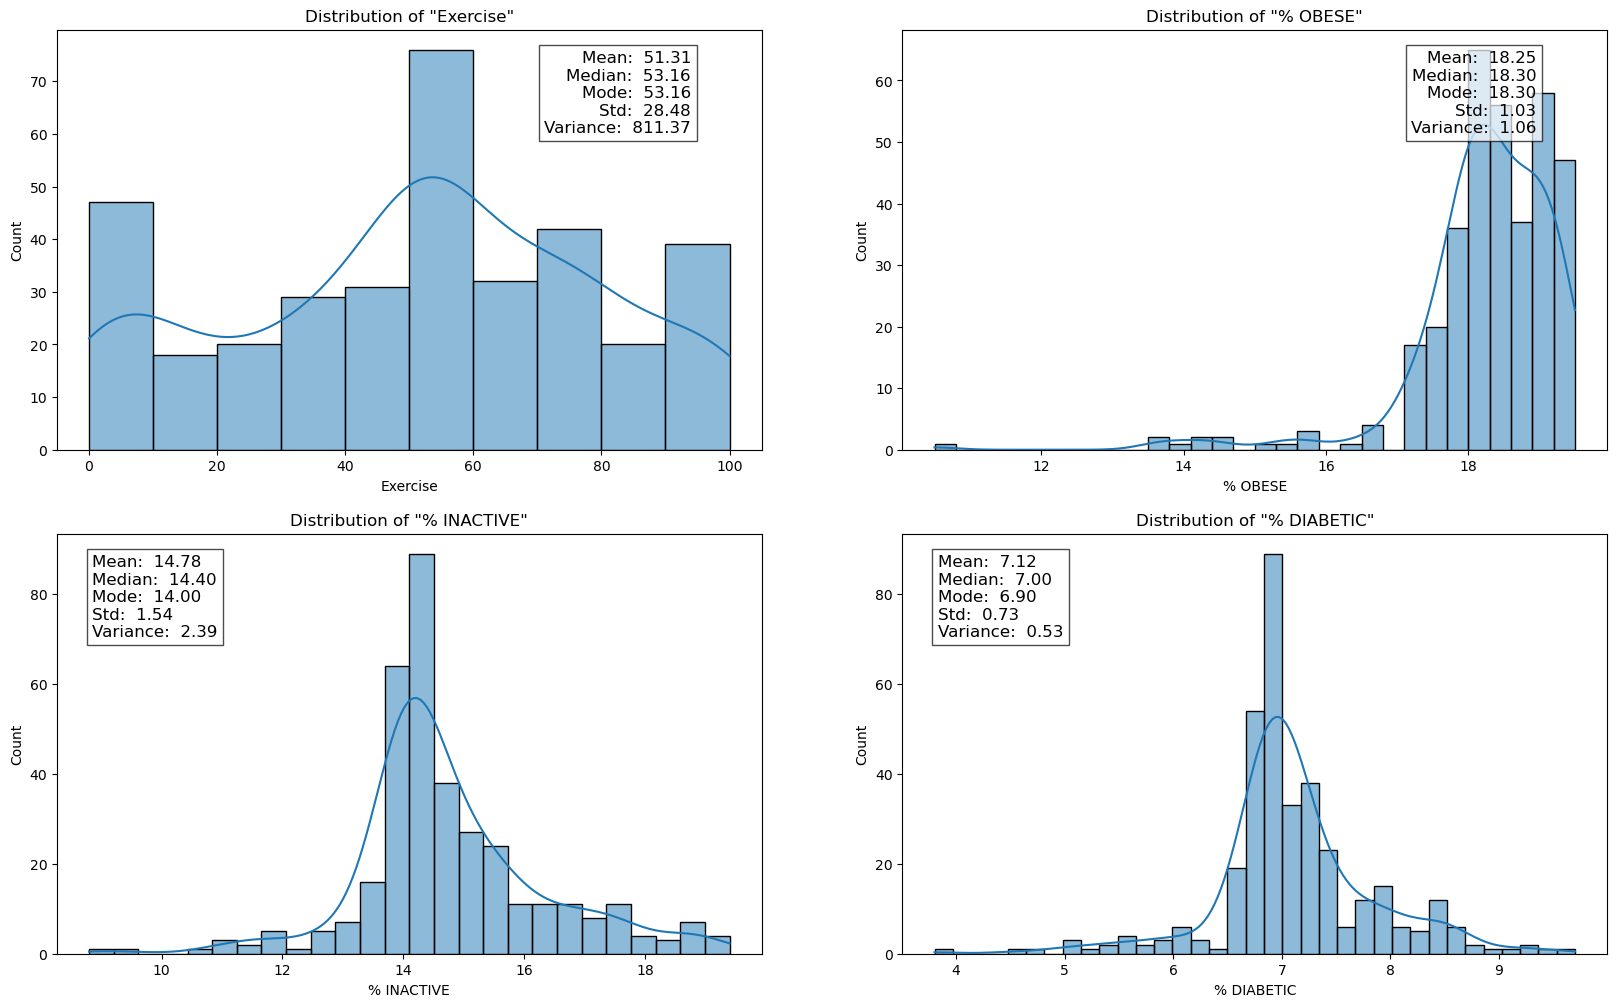

In [28]:
fig, ax = plt.subplots(2, int(len(numerical_features) / 2), figsize=(20, 12))

row, col = 0, 0
for feature in numerical_features:
    
    mean = temp_dataset[feature].mean()
    median = temp_dataset[feature].median()
    mode = temp_dataset[feature].mode().values[0]
    std = temp_dataset[feature].std()
    variance = temp_dataset[feature].var()
    
    sns.histplot(temp_dataset[feature], ax = ax[row, col], kde=True)
    ax[row, col].set_title('Distribution of "{}"'.format(feature))
    
    stats_text = f"Mean: {mean: .2f}\nMedian: {median: .2f}\nMode: {mode: .2f}\nStd: {std: .2f}\nVariance: {variance: .2f}"
    
    if row == 0:
        ax[row, col].text(
            0.9, 0.95, stats_text, transform = ax[row, col].transAxes, 
            fontsize = 12, horizontalalignment = 'right', verticalalignment = 'top', bbox = dict(facecolor = 'white', alpha = 0.7))
    else:
        ax[row, col].text(
            0.05, 0.95, stats_text, transform = ax[row, col].transAxes, 
            fontsize = 12, horizontalalignment = 'left', verticalalignment = 'top', bbox = dict(facecolor = 'white', alpha = 0.7))
    
    col = col + 1
    if col == ax.shape[1]:
        row = row + 1
        col = 0
        
plt.show()

**As we can see that, only "% INACTIVE" and "% DIABETIC" are close to normal distribution.**<br>
**Exercise is not a normal distribution.**<br>
**"% OBESE" is extremely left skewed.**

# Q-Q Plots

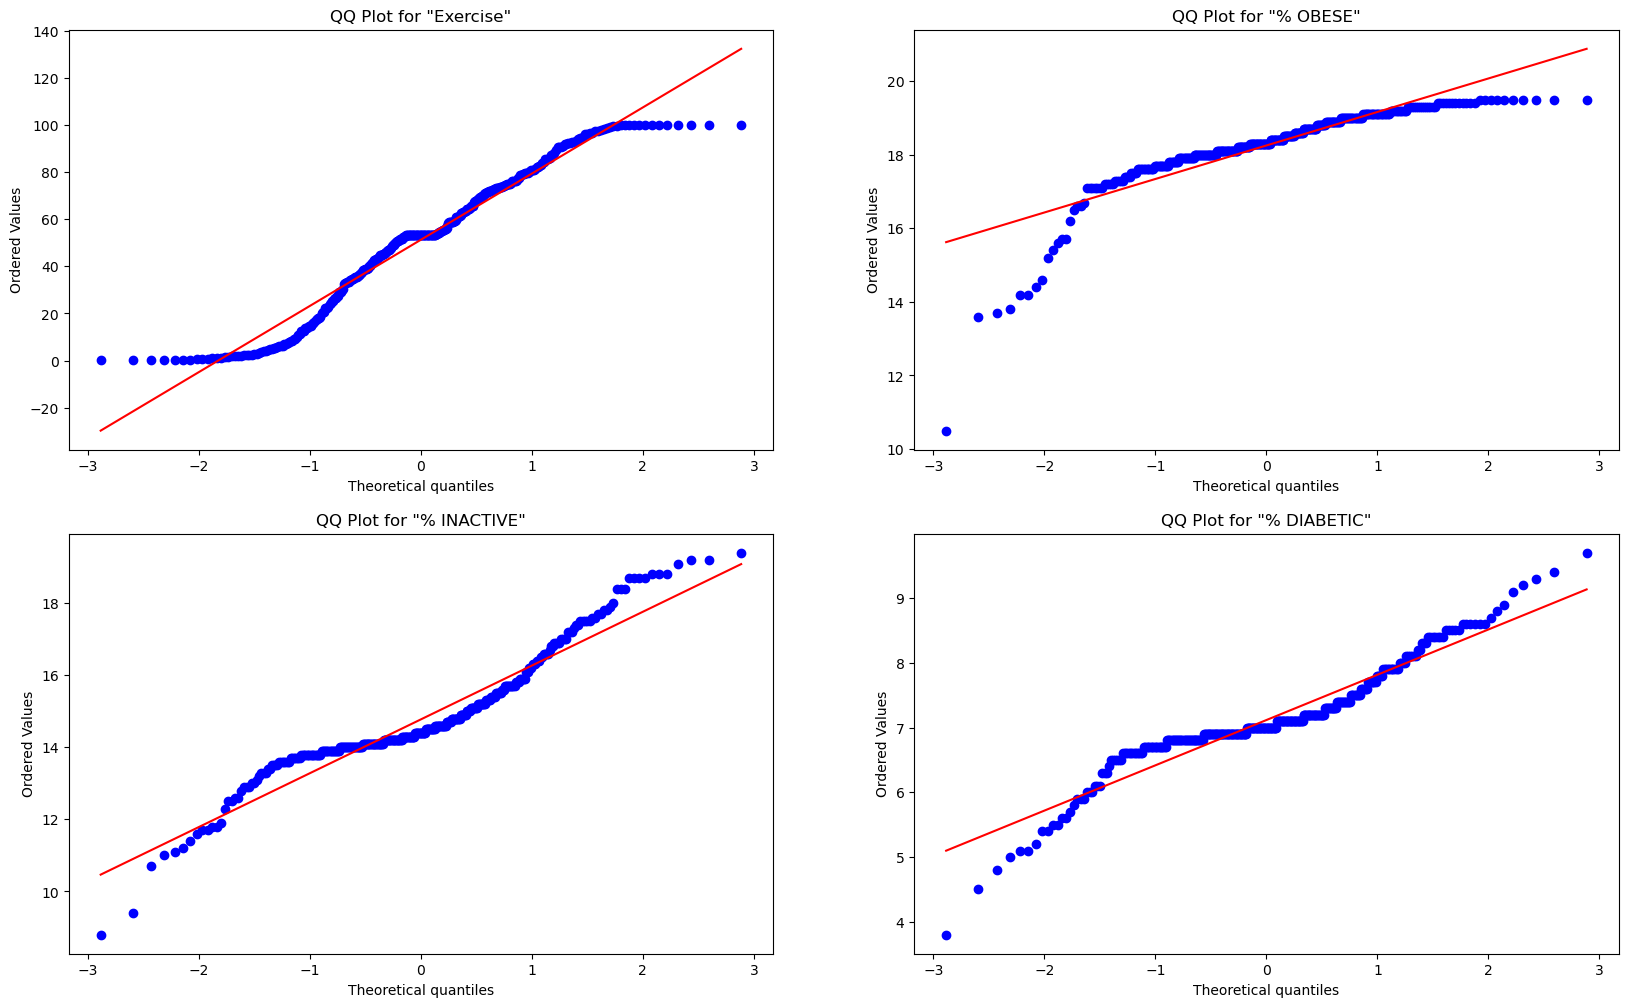

In [29]:
fig, ax = plt.subplots(2, int(len(numerical_features) / 2), figsize=(20, 12))

row, col = 0, 0
for feature in numerical_features:
   
    stats.probplot(temp_dataset[feature], dist = "norm", plot = ax[row, col])
    ax[row, col].set_title(f'QQ Plot for "{feature}"')

    col = col + 1
    if col == ax.shape[1]:
        row = row + 1
        col = 0

plt.show()

### Does Access to Exercise affect the % DIABETIC Rates significantly?

#### Independent t-test

**Null Hypothesis (H0): There is no significant relationship between 'Access to Exercise Opportunities' and '% DIABETIC Rates'.**<br>
**Alternative Hypothesis (Ha): There is significant relationship between 'Access to Exercise Opportunities' and '% DIABETIC Rates'.**

In [30]:
pearson_corr, p_value = stats.pearsonr(temp_dataset['Exercise'], temp_dataset['% DIABETIC'])

print("Pearson Correlation Coefficient:", pearson_corr)
print("P-Value:", p_value)
print("The analogy is, if you flip a fair coin then the probability of getting",round(-math.log2(p_value)),"number of heads continously, is the same as the probability of the Null Hypothesis being right.")
alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis.Therefore, there is a significant relationship between 'Access to Exercise Opportunities' and '% DIABETIC Rates'.")
else:
    print("Fail to reject the null hypothesis.Therefore, there is no significant relationship between 'Access to Exercise Opportunities' and '% DIABETIC Rates'.")


Pearson Correlation Coefficient: -0.2986975111084101
P-Value: 9.957552013407762e-09
The analogy is, if you flip a fair coin then the probability of getting 27 number of heads continously, is the same as the probability of the Null Hypothesis being right.
Reject the null hypothesis.Therefore, there is a significant relationship between 'Access to Exercise Opportunities' and '% DIABETIC Rates'.


# Simple Linear Regression with Exercise as Factor

In [34]:
temp_dataset['intercept'] = 1

X = temp_dataset[['Exercise','intercept']]
y = temp_dataset['% DIABETIC']

# Feature Scaling
scaler = StandardScaler()
X = scaler.fit_transform(X)
y = scaler.fit_transform(y.values.reshape(-1, 1))

model = sm.OLS(y, X).fit()
summary = model.summary()

print(summary)


                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.089
Model:                            OLS   Adj. R-squared (uncentered):              0.087
Method:                 Least Squares   F-statistic:                              34.58
Date:                Fri, 06 Oct 2023   Prob (F-statistic):                    9.49e-09
Time:                        22:09:55   Log-Likelihood:                         -485.76
No. Observations:                 354   AIC:                                      973.5
Df Residuals:                     353   BIC:                                      977.4
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

/Users/rahul/anaconda3/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1965: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sqrt(eigvals[0]/eigvals[-1])


## Multiple Linear Regression (All Features)

In [35]:
temp_dataset['intercept'] = 1

X = temp_dataset[['Exercise', '% OBESE', '% INACTIVE',
       'intercept']]
y = temp_dataset['% DIABETIC']

# Feature Scaling
scaler = StandardScaler()
X = scaler.fit_transform(X)
y = scaler.fit_transform(y.values.reshape(-1, 1))

model = sm.OLS(y, X).fit()
summary = model.summary()

print(summary)


                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.369
Model:                            OLS   Adj. R-squared (uncentered):              0.363
Method:                 Least Squares   F-statistic:                              68.39
Date:                Fri, 06 Oct 2023   Prob (F-statistic):                    7.57e-35
Time:                        22:10:07   Log-Likelihood:                         -420.84
No. Observations:                 354   AIC:                                      847.7
Df Residuals:                     351   BIC:                                      859.3
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

/Users/rahul/anaconda3/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1965: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sqrt(eigvals[0]/eigvals[-1])


## Multiple Linear Regression (With Interaction Terms)

In [36]:
temp_dataset['Interaction_Term_1'] = temp_dataset['% OBESE'] * temp_dataset['% INACTIVE']
temp_dataset['Interaction_Term_2'] = temp_dataset['% OBESE'] * temp_dataset['Exercise']
temp_dataset['Interaction_Term_3'] = temp_dataset['Exercise'] * temp_dataset['% INACTIVE']
temp_dataset['Interaction_Term_4'] = temp_dataset['Exercise'] * temp_dataset['Exercise']
temp_dataset['Interaction_Term_5'] = temp_dataset['% INACTIVE'] * temp_dataset['% INACTIVE']
temp_dataset['Interaction_Term_6'] = temp_dataset['% OBESE'] * temp_dataset['% OBESE']

temp_dataset['intercept'] = 1

X = temp_dataset[['Exercise', '% OBESE', '% INACTIVE', 'Interaction_Term_1', 
       'Interaction_Term_2', 'Interaction_Term_3', 'Interaction_Term_4',
       'Interaction_Term_5', 'Interaction_Term_6','intercept']]
y = temp_dataset['% DIABETIC']

# Feature Scaling
scaler = StandardScaler()
X = scaler.fit_transform(X)
y = scaler.fit_transform(y.values.reshape(-1, 1))

model = sm.OLS(y, X).fit()
summary = model.summary()

print(summary)


                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.415
Model:                            OLS   Adj. R-squared (uncentered):              0.399
Method:                 Least Squares   F-statistic:                              27.14
Date:                Fri, 06 Oct 2023   Prob (F-statistic):                    2.26e-35
Time:                        22:10:18   Log-Likelihood:                         -407.56
No. Observations:                 354   AIC:                                      833.1
Df Residuals:                     345   BIC:                                      867.9
Df Model:                           9                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

/Users/rahul/anaconda3/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1965: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sqrt(eigvals[0]/eigvals[-1])


**1. When considering only Access to Exercise for simple linear regression, only 9.9% variation in % DIABETIC can be explained by it. The Accuracy of the model is 70.02%**<br>
**2. When considering all features for multiple linear regression, 38.2% variation in % DIABETIC can be explained by all the features. The Accuracy of the model is 88.04%**<br>
**3. When considering all features with interaction terms for multiple linear regression, 43.4% variation in % DIABETIC can be explained by all the features. The Accuracy of the model is 90.35%**<br>
<br>
**As you can see that the accuracy keeps increasing as the dimensionality increases**
